In [1]:
import pandas as pd
import numpy as np
import copy
import sympy

np.random.seed(42)

In [2]:
def generate_instance():
    # iç veri
    ay = np.max([1.0, np.round(np.random.normal(3, 0.5))]) if np.random.rand() > 0.95 else np.max([1.0, np.round(np.random.normal(28, 10))])
    kredi_karti_baska_banka = 1.0 if np.random.rand() > 0.9 else 0.0
    kredi_karti_aldi = 1.0 if np.random.rand() > 0.99 else 0.0
    kredi_karti_banka = 1.0 if np.random.rand() > 0.7 else 0.0
    
    kredi_karti_ilk_ay_harcama = 0.0
    
    if kredi_karti_banka == 1.0 or kredi_karti_aldi == 1.0:
        kredi_karti_ilk_ay_harcama = np.max([0.0, np.random.normal(1000.0, 250.0)])
    
    kredi_karti_harcama = 0.0
    if kredi_karti_banka == 1.0 or kredi_karti_aldi == 1.0 or kredi_karti_baska_banka == 1.0:
        kredi_karti_harcama = np.max([0.0, np.random.normal(-500, 1000)]) if np.random.rand() > 0.4 else np.max([0.0, np.random.normal(3000, 2000)])
    
    kredi_karti_harcama_onceki_ay = 0.0
    if ay > 1 and (kredi_karti_banka == 1.0 or kredi_karti_aldi == 1.0 or kredi_karti_baska_banka == 1.0):
        eps = np.random.normal(100, 10)
        kredi_karti_harcama_onceki_ay = np.max([0.0, np.random.normal(500, 500) + eps]) if np.random.rand() > 0.4 else np.max([0.0, np.random.normal(3000, 2000) + eps])
    
    toplam_varlik = np.max([0.0, np.random.normal(-1000, 4000)]) if np.random.rand() > 0.4 else np.max([0.0, np.random.normal(10000, 8000)])
    toplam_varlik_onceki_ay = 0.0
    toplam_varlik_iki_onceki_ay = 0.0
    toplam_varlik_onceki_3_ay_ortalama = 0.0
    if ay > 3:
        eps = np.random.normal(200, 25)
        toplam_varlik_onceki_ay = np.max([0.0, np.random.normal(2500, 3000) + eps]) if np.random.rand() > 0.5 else np.max([0.0, np.random.normal(10000, 8000) + eps])
        eps = np.random.normal(200, 25)
        toplam_varlik_iki_onceki_ay = np.max([0.0, np.random.normal(2500, 3000) + eps]) if np.random.rand() > 0.5 else np.max([0.0, np.random.normal(10000, 8000) + eps])
        eps = np.random.normal(200, 25)
        toplam_varlik_uc_onceki_ay = np.max([0.0, np.random.normal(2500, 3000) + eps]) if np.random.rand() > 0.5 else np.max([0.0, np.random.normal(10000, 8000) + eps])
        toplam_varlik_onceki_3_ay_ortalama = (toplam_varlik_onceki_ay + toplam_varlik_iki_onceki_ay + toplam_varlik_uc_onceki_ay) / 3
    
    acik_kredi = 1.0 if np.random.rand() > 0.83 else 0.0
    onceki_ay_urun_sayisi = np.max([0.0, np.round(np.random.normal(4.0, 1.5))])
    urun_sayisi = 0.0 if np.random.rand() > 0.9 else np.max([0.0, np.round(np.random.normal(3.0, 2.0))])
    
    # performans ölçütleri
    yeni_musteri = 1.0 if ay <= 3.0 else 0.0
    capraz_satis = 1.0 if ay > 3.0 and (kredi_karti_baska_banka == 0.0 and kredi_karti_ilk_ay_harcama > 100.0) and np.random.rand() > 0.8 else 0.0
    yukari_satis = 1.0 if ay > 3.0 and (toplam_varlik_onceki_ay > 10000 and toplam_varlik / toplam_varlik_onceki_3_ay_ortalama > 1.5) else 0.0
    
    devam_eden_musteri = 0.0
    terk = 0.0
    geri_kazanilmis_musteri = 0.0
    pasif_musteri = 0.0
    aktiflestirilmis_musteri = 0.0
    
    if ay > 3 and kredi_karti_harcama == 0.0 and toplam_varlik < 50.0 and acik_kredi == 0 and urun_sayisi == 0:
        pasif_musteri = 1.0
    elif ay > 3 and (onceki_ay_urun_sayisi > 0 or toplam_varlik_onceki_ay > 0 or kredi_karti_harcama_onceki_ay > 0) and urun_sayisi == 0 and toplam_varlik < 50:
        terk = 1.0
    elif ay > 3 and toplam_varlik_onceki_ay == 0.0 and kredi_karti_harcama_onceki_ay == 0.0 and toplam_varlik_onceki_ay == 0.0 and urun_sayisi > 0 and toplam_varlik > 0:
        aktiflestirilmis_musteri = 1.0
    elif ay > 3 and onceki_ay_urun_sayisi == 0.0 and urun_sayisi > 0:
        geri_kazanilmis_musteri = 1.0
    elif ay > 3:
        devam_eden_musteri = 1.0
    
    # digital
    basarili_giris_sayisi = 0.0
    gezdigi_sayfa_sayisi = 0.0
    hata_islem_sayisi = 0.0
    islem_ortalama_tiklama = 0.0
    cevrim_ici_sure = 0.0
    
    # classic
    personel_ilgisi = 0.0
    atm_kullanim = 0.0
    sube_kullanim = 0.0
    sube_sure = 0.0
    
    # social media
    takip = 0.0
    begeni = 0.0
    pozitif_yorum = np.max([0.0, np.round(np.random.normal(0.7, 0.75))])
    negatif_yorum = np.max([0.0, np.round(np.random.normal(0.3, 0.15))])
    sosyal_medya_reklamlari = 0.0 
    
    gelir = np.random.normal(100, 200)
    
    if yeni_musteri == 1.0:
        basarili_giris_sayisi = np.max([0.0, np.round(np.random.normal(5, 0.5))])
        gezdigi_sayfa_sayisi = np.max([0.0, np.round(np.random.normal(2, 0.35))])
        hata_islem_sayisi = np.max([0.0, np.round(np.random.normal(0.9, 0.4))])
        islem_ortalama_tiklama = np.max([0.0, np.round(np.random.normal(6, 0.5))])
        cevrim_ici_sure = np.max([0.0, np.random.normal(6, 0.5)])
        atm_kullanim = np.max([0.0, np.round(np.random.normal(1, 0.1))])
        sube_kullanim = np.max([0.0, np.round(np.random.normal(1, 0.2))])
        sube_sure = np.max([0.0, np.random.normal(0.5, 0.3)])
        personel_ilgisi = np.max([0.0, np.random.normal(3.0, 0.15)]) if sube_kullanim > 0 else 3.5
        takip = 1.0 if np.random.rand() > 0.7 else 0.0
        begeni = 1.0 if np.random.rand() > 0.95 else 0.0
        pozitif_yorum = np.max([0.0, np.round(np.random.normal(0.7, 0.75))])
        negatif_yorum = np.max([0.0, np.round(np.random.normal(0.3, 0.15))])
        gelir = np.max([0.0, np.round(np.random.normal(1000, 2000))])
        sosyal_medya_reklamlari = np.max([0.0, np.round(np.random.normal(3.5, 0.2))])
    elif devam_eden_musteri == 1.0:
        basarili_giris_sayisi = np.max([0.0, np.round(np.random.normal(15, 0.25))])
        gezdigi_sayfa_sayisi = np.max([0.0, np.round(np.random.normal(4, 0.5))])
        hata_islem_sayisi = np.max([0.0, np.round(np.random.normal(1.1, 0.2))])
        islem_ortalama_tiklama = np.max([0.0, np.round(np.random.normal(4, 0.5))])
        cevrim_ici_sure = np.max([0.0, np.random.normal(10, 0.5)])
        atm_kullanim = np.max([0.0, np.round(np.random.normal(3, 0.25))])
        sube_kullanim = np.max([0.0, np.round(np.random.normal(2, 0.2))])
        sube_sure = np.max([0.0, np.random.normal(1.0, 0.3)])
        personel_ilgisi = np.max([0.0, np.random.normal(3.5, 0.15)]) if sube_kullanim > 0 else 3.5
        takip = 1.0 if np.random.rand() > 0.5 else 0.0
        begeni = 1.0 if np.random.rand() > 0.85 else 0.0
        pozitif_yorum = np.max([0.0, np.round(np.random.normal(1.1, 0.85))])
        negatif_yorum = np.max([0.0, np.round(np.random.normal(0.4, 0.22))])
        gelir = np.max([0.0, np.round(np.random.normal(3000, 2000))])
        sosyal_medya_reklamlari = np.max([0.0, np.round(np.random.normal(2.8, 0.6))])
    elif terk == 1.0:
        basarili_giris_sayisi = np.max([0.0, np.round(np.random.normal(1.5, 0.2))])
        gezdigi_sayfa_sayisi = np.max([0.0, np.round(np.random.normal(2.0, 0.75))])
        hata_islem_sayisi = np.max([0.0, np.round(np.random.normal(4.0, 0.5))])
        islem_ortalama_tiklama = np.max([0.0, np.round(np.random.normal(9, 0.8))])
        cevrim_ici_sure = np.max([0.0, np.random.normal(2, 0.5)])
        atm_kullanim = np.max([0.0, np.round(np.random.normal(0.5, 0.05))])
        sube_kullanim = np.max([0.0, np.round(np.random.normal(3, 0.5))])
        sube_sure = np.max([0.0, np.random.normal(6.0, 0.5)])
        personel_ilgisi = np.max([0.0, np.random.normal(1.5, 0.19)]) if sube_kullanim > 0 else 3.5
        takip = 1.0 if np.random.rand() > 0.6 else 0.0
        begeni = 1.0 if np.random.rand() > 0.995 else 0.0
        pozitif_yorum = np.max([0.0, np.round(np.random.normal(0.3, 0.25))])
        negatif_yorum = np.max([0.0, np.round(np.random.normal(2.8, 0.5))])
        gelir = np.max([0.0, np.round(np.random.normal(500, 250))])
        sosyal_medya_reklamlari = np.max([0.0, np.round(np.random.normal(2.9, 0.33))])
    elif geri_kazanilmis_musteri == 1.0:
        basarili_giris_sayisi = np.max([0.0, np.round(np.random.normal(3, 0.1))])
        gezdigi_sayfa_sayisi = np.max([0.0, np.round(np.random.normal(1.5, 0.3))])
        hata_islem_sayisi = np.max([0.0, np.round(np.random.normal(0.2, 0.1))])
        islem_ortalama_tiklama = np.max([0.0, np.round(np.random.normal(6, 0.5))])
        cevrim_ici_sure = np.max([0.0, np.random.normal(4, 0.2)])
        atm_kullanim = np.max([0.0, np.round(np.random.normal(0.75, 0.2))])
        sube_kullanim = np.max([0.0, np.round(np.random.normal(2.5, 0.1))])
        sube_sure = np.max([0.0, np.random.normal(0.25, 0.3)])
        personel_ilgisi = np.max([0.0, np.random.normal(4.5, 0.35)]) if sube_kullanim > 0 else 3.5
        takip = 1.0 if np.random.rand() > 0.6 else 0.0
        begeni = 1.0 if np.random.rand() > 0.96 else 0.0
        pozitif_yorum = np.max([0.0, np.round(np.random.normal(0.85, 0.17))])
        negatif_yorum = np.max([0.0, np.round(np.random.normal(0.4, 0.42))])
        gelir = np.max([0.0, np.round(np.random.normal(2500, 600))])
        sosyal_medya_reklamlari = np.max([0.0, np.round(np.random.normal(3.9, 0.13))])
    elif aktiflestirilmis_musteri == 1.0:
        basarili_giris_sayisi = np.max([0.0, np.round(np.random.normal(4.3, 0.2))])
        gezdigi_sayfa_sayisi = np.max([0.0, np.round(np.random.normal(2, 0.5))])
        hata_islem_sayisi = np.max([0.0, np.round(np.random.normal(0.1, 0.1))])
        islem_ortalama_tiklama = np.max([0.0, np.round(np.random.normal(4, 0.5))])
        cevrim_ici_sure = np.max([0.0, np.random.normal(5, 0.5)])
        atm_kullanim = np.max([0.0, np.round(np.random.normal(1.2, 0.4))])
        sube_kullanim = np.max([0.0, np.round(np.random.normal(0.5, 0.1))])
        personel_ilgisi = np.max([0.0, np.random.normal(3.95, 0.45)]) if sube_kullanim > 0 else 3.5
        sube_sure = np.max([0.0, np.random.normal(0.25, 0.2)])
        takip = 1.0 if np.random.rand() > 0.76 else 0.0
        begeni = 1.0 if np.random.rand() > 0.99 else 0.0
        pozitif_yorum = np.max([0.0, np.round(np.random.normal(1.32, 0.39))])
        negatif_yorum = np.max([0.0, np.round(np.random.normal(0.5, 0.35))])
        gelir = np.max([0.0, np.round(np.random.normal(3500, 900))])
        sosyal_medya_reklamlari = np.max([0.0, np.round(np.random.normal(4.1, 0.01))])
        
    tavsiye = np.random.normal(6.5, 0.25) # bias
    tavsiye += yeni_musteri * np.random.normal(1.5, 0.2)
    tavsiye += capraz_satis * np.random.normal(2, 0.5)
    tavsiye += yukari_satis * np.random.normal(4, 0.1)
    tavsiye += devam_eden_musteri * np.random.normal(0.5, 0.05)
    tavsiye += terk * np.random.normal(-4.0, 0.002)
    tavsiye += geri_kazanilmis_musteri * np.random.normal(1.0, 0.5)
    tavsiye += aktiflestirilmis_musteri * np.random.normal(0.5, 0.75)
    tavsiye += pasif_musteri * np.random.normal(-1.75, 0.55)
    
    tavsiye += basarili_giris_sayisi * np.random.normal(0.25, 0.2)
    tavsiye += gezdigi_sayfa_sayisi * np.random.normal(0.11, 0.05)
    tavsiye += hata_islem_sayisi * np.random.normal(-2.5, 0.01)
    tavsiye += (islem_ortalama_tiklama - 5.15) * np.random.normal(-0.3, 0.35)
    tavsiye += (cevrim_ici_sure - np.random.normal(4.15, 0.35)) * np.random.normal(0.3, 0.1)
    
    tavsiye += (personel_ilgisi - 3.5) * np.random.normal(0.7, 0.2)
    tavsiye += atm_kullanim * np.random.normal(0.5, 0.4)
    tavsiye += sube_kullanim * np.random.normal(0.1, 0.05)
    tavsiye += (sube_sure - 0.25) * np.random.normal(-2.5, 0.05)
    
    tavsiye += begeni * np.random.normal(0.5, 0.25)
    tavsiye += takip * np.random.normal(0.1, 0.01)
    tavsiye += pozitif_yorum * np.random.normal(0.9, 0.4)
    tavsiye += negatif_yorum * np.random.normal(-1.8, 0.1)
    
    tavsiye += (urun_sayisi - 3.75) * np.random.normal(0.85, 0.3)
    tavsiye += 0 if toplam_varlik > 50 else np.random.normal(-0.75, 0.28)
    tavsiye += (acik_kredi - 1) * np.random.normal(0.3, 0.07)
    tavsiye += np.random.normal(-0.75, 0.15) if (onceki_ay_urun_sayisi - urun_sayisi) and urun_sayisi == 0 > 0 else 0.0

    tavsiye += np.random.normal(-0.5, 0.15)
    tavsiye = np.round(tavsiye)
    tavsiye = np.max([0.0, tavsiye])
    tavsiye = np.min([10.0, tavsiye])
    
    memnuniyet = np.random.normal(30.0, 4.0)
    
    memnuniyet += yeni_musteri * np.random.normal(1.5, 0.5)
    memnuniyet += capraz_satis * np.random.normal(14, 2.0)
    memnuniyet += yukari_satis * np.random.normal(35, 5.0)
    memnuniyet += devam_eden_musteri * np.random.normal(3.0, 1.0)
    memnuniyet += terk * np.random.normal(-35.0, 5.0)
    memnuniyet += geri_kazanilmis_musteri * np.random.normal(1.25, 2.5)
    memnuniyet += aktiflestirilmis_musteri * np.random.normal(1.5, 0.95)
    memnuniyet += pasif_musteri * np.random.normal(-15.5, 3.75)
    
    memnuniyet += basarili_giris_sayisi * np.random.normal(3, 1.1)
    memnuniyet += ay * np.random.normal(1.5, 0.2)
    memnuniyet += gezdigi_sayfa_sayisi * np.random.normal(0.65, 0.15)
    memnuniyet += hata_islem_sayisi * np.random.normal(-8.5, 1.65)
    memnuniyet += (islem_ortalama_tiklama - 5.5) * np.random.normal(-1.2, 0.25)
    memnuniyet += (cevrim_ici_sure - np.random.normal(4.5, 0.5)) * np.random.normal(0.9, 0.3)
    
    memnuniyet += (personel_ilgisi - 3.5) * np.random.normal(5.7, 1.2)
    memnuniyet += atm_kullanim * np.random.normal(3.2, 0.62)
    memnuniyet += sube_kullanim * np.random.normal(-0.3, 0.5)
    memnuniyet += (sube_sure - 0.25) * np.random.normal(-10.5, 0.5)
    
    memnuniyet += begeni * np.random.normal(0.5, 0.15)
    memnuniyet += takip * np.random.normal(0.1, 0.01)
    memnuniyet += pozitif_yorum * np.random.normal(1.6, 0.32)
    memnuniyet += negatif_yorum * np.random.normal(-8.2, 1.3)
    
    memnuniyet += (urun_sayisi - 3) * np.random.normal(1.0, 0.01)
    memnuniyet += np.random.normal(1.0, 0.25) if toplam_varlik > 50 else np.random.normal(-5.25, 2.6)
    memnuniyet += (kredi_karti_banka - 1) * np.random.normal(7.0, 1.5)
    memnuniyet += np.random.normal(-6.5, 2.35) if (onceki_ay_urun_sayisi - urun_sayisi) and urun_sayisi == 0 > 0 else 0.0
    
    memnuniyet += np.random.normal(-12, 3.0)
    memnuniyet = np.round(memnuniyet)
    memnuniyet = np.max([0.0, memnuniyet])
    memnuniyet = np.min([100.0, memnuniyet])
    
    instance = [tavsiye, memnuniyet,
                #ay,
                #kredi_karti_baska_banka, kredi_karti_aldi, kredi_karti_banka, kredi_karti_ilk_ay_harcama, kredi_karti_harcama, kredi_karti_harcama_onceki_ay,
                #toplam_varlik, toplam_varlik_onceki_ay, toplam_varlik_iki_onceki_ay, toplam_varlik_onceki_3_ay_ortalama,
                #acik_kredi,
                #onceki_ay_urun_sayisi, urun_sayisi,
                yeni_musteri, capraz_satis, yukari_satis, devam_eden_musteri, terk, geri_kazanilmis_musteri, pasif_musteri, aktiflestirilmis_musteri,
                basarili_giris_sayisi, gezdigi_sayfa_sayisi, hata_islem_sayisi, islem_ortalama_tiklama, cevrim_ici_sure,
                sube_kullanim, sube_sure, atm_kullanim, personel_ilgisi,
                takip, begeni, pozitif_yorum, negatif_yorum, sosyal_medya_reklamlari,
                gelir
               ]
    
    return np.array(instance)
    
    
    
    

In [3]:
samples = np.array([generate_instance() for x in range(20000)])
columns = ["tavsiye", "memnuniyet",
                #"ay",
                #"kredi_karti_baska_banka", "kredi_karti_aldi", "kredi_karti_banka", "kredi_karti_ilk_ay_harcama", "kredi_karti_harcama", "kredi_karti_harcama_onceki_ay",
                #"toplam_varlik", "toplam_varlik_onceki_ay", "toplam_varlik_iki_onceki_ay", "toplam_varlik_onceki_3_ay_ortalama",
                #"acik_kredi",
                #"onceki_ay_urun_sayisi", "urun_sayisi",
                "yeni_musteri", "capraz_satis", "yukari_satis", "devam_eden_musteri", "terk", "geri_kazanilmis_musteri", "pasif_musteri", "aktiflestirilmis_musteri",
                "basarili_giris_sayisi", "gezdigi_sayfa_sayisi", "hata_islem_sayisi", "islem_ortalama_tiklama", "cevrim_ici_sure",
                "sube_kullanim", "sube_sure","atm_kullanim", "personel_ilgisi",
                "takip", "begeni", "pozitif_yorum", "negatif_yorum", "sosyal_medya_reklamlari",
          "gelir"]
data = pd.DataFrame(samples, columns = columns)

In [4]:
data["yeni_musteri"].sum() / data.shape[0]

0.0471

In [5]:
data["capraz_satis"].sum() / data.shape[0]

0.0509

In [6]:
data["yukari_satis"].sum() / data.shape[0]

0.03045

In [7]:
data["devam_eden_musteri"].sum() / data.shape[0]

0.8256

In [8]:
data["terk"].sum() / data.shape[0]

0.02855

In [9]:
data["geri_kazanilmis_musteri"].sum() / data.shape[0]

0.0067

In [10]:
data["pasif_musteri"].sum() / data.shape[0]

0.05015

In [11]:
#data["aktiflestirilmis_musteri"].sum() / data.shape[0]

In [12]:
data["tavsiye"].mean()

7.47585

In [13]:
data["memnuniyet"].mean()

81.4283

In [14]:
data.var()

tavsiye                     1.018793e+01
memnuniyet                  8.161258e+02
yeni_musteri                4.488383e-02
capraz_satis                4.831161e-02
yukari_satis                2.952427e-02
devam_eden_musteri          1.439918e-01
terk                        2.773628e-02
geri_kazanilmis_musteri     6.655443e-03
pasif_musteri               4.763736e-02
aktiflestirilmis_musteri    4.014640e-02
basarili_giris_sayisi       2.257080e+01
gezdigi_sayfa_sayisi        1.418719e+00
hata_islem_sayisi           4.003700e-01
islem_ortalama_tiklama      2.064432e+00
cevrim_ici_sure             7.754675e+00
sube_kullanim               3.718634e-01
sube_sure                   8.772902e-01
atm_kullanim                8.770735e-01
personel_ilgisi             7.219674e-01
takip                       2.470964e-01
begeni                      1.074236e-01
pozitif_yorum               6.812592e-01
negatif_yorum               3.866152e-01
sosyal_medya_reklamlari     8.645915e-01
gelir           

In [15]:
data = (data - data.min()) / (data.max() - data.min())

In [16]:
data.cov()

,tavsiye,memnuniyet,yeni_musteri,capraz_satis,yukari_satis,devam_eden_musteri,terk,geri_kazanilmis_musteri,pasif_musteri,aktiflestirilmis_musteri,...,sube_kullanim,sube_sure,atm_kullanim,personel_ilgisi,takip,begeni,pozitif_yorum,negatif_yorum,sosyal_medya_reklamlari,gelir
tavsiye,0.101879,0.053118,-0.007737,0.004438,0.006181,0.058457,-0.021345,0.000636,-0.034158,0.004146,...,0.012241,-0.011015,0.041076,0.031050,0.020293,0.011226,0.013047,-0.015472,0.018728,0.013693
memnuniyet,0.053118,0.081613,-0.027195,0.005110,0.005449,0.085900,-0.023249,-0.000831,-0.031639,-0.002986,...,0.017981,-0.009649,0.054009,0.031285,0.023428,0.011340,0.009598,-0.013046,0.012541,0.016313
yeni_musteri,-0.007737,-0.027195,0.044884,-0.002398,-0.001434,-0.038888,-0.001345,-0.000316,-0.002362,-0.001974,...,-0.009690,-0.003338,-0.018766,-0.002191,-0.007257,-0.003315,-0.003080,-0.003429,0.006913,-0.005338
capraz_satis,0.004438,0.005110,-0.002398,0.048312,-0.000400,0.004477,0.000947,0.000009,-0.001103,-0.001933,...,0.002180,0.001172,0.002308,0.000427,-0.000351,0.000920,-0.000102,0.000772,-0.000368,-0.000026
yukari_satis,0.006181,0.005449,-0.001434,-0.000400,0.029524,0.005161,-0.000869,-0.000054,-0.001527,-0.001276,...,0.001394,-0.000201,0.002931,0.001289,0.000919,0.000673,0.000412,-0.000246,0.000555,0.000844
devam_eden_musteri,0.058457,0.085900,-0.038888,0.004477,0.005161,0.143992,-0.023572,-0.005532,-0.041406,-0.034594,...,0.036870,-0.003613,0.083812,0.036317,0.040484,0.018047,0.009330,-0.011265,0.007726,0.019390
terk,-0.021345,-0.023249,-0.001345,0.000947,-0.000869,-0.023572,0.027736,-0.000191,-0.001432,-0.001196,...,0.008322,0.018888,-0.015075,-0.009266,-0.001233,-0.003395,-0.004927,0.017073,0.000830,-0.005310
geri_kazanilmis_musteri,0.000636,-0.000831,-0.000316,0.000009,-0.000054,-0.005532,-0.000191,0.006655,-0.000336,-0.000281,...,0.001099,-0.000631,-0.002882,0.001569,-0.000588,-0.000520,-0.000129,-0.000012,0.001663,-0.000155
pasif_musteri,-0.034158,-0.031639,-0.002362,-0.001103,-0.001527,-0.041406,-0.001432,-0.000336,0.047637,-0.002101,...,-0.022842,-0.006948,-0.032520,-0.030049,-0.022368,-0.006139,-0.003270,-0.003557,-0.027597,-0.011026
aktiflestirilmis_musteri,0.004146,-0.002986,-0.001974,-0.001933,-0.001276,-0.034594,-0.001196,-0.000281,-0.002101,0.040146,...,-0.013759,-0.004359,-0.014569,0.003621,-0.009038,-0.004679,0.002075,0.001190,0.010465,0.002440


In [17]:
D, V = np.linalg.eig(data.cov())
D

array([ 5.45934988e-01,  2.27216312e-01,  1.05577748e-01,  1.03730400e-01,
        1.00797261e-01,  5.31263201e-02,  4.86805777e-02,  3.96226869e-02,
        2.89510755e-02,  2.45716285e-02,  2.04850896e-02,  1.41926793e-02,
        1.26546593e-02,  1.06880229e-02,  8.73002812e-03,  7.80472099e-03,
        3.06984706e-03,  2.32017617e-03,  1.64104381e-03,  1.25042033e-03,
        1.22071597e-03,  6.87833183e-04,  5.58722510e-04,  1.61988304e-04,
       -1.01427114e-16])

In [18]:
for i in range(len(data.columns)):
    c = copy.deepcopy(list(data.columns))
    var = c.pop(i)
    D, V = np.linalg.eig(data[c].cov())
    print("index: {}, eigen_vals: {}\n".format(var, D))

index: tavsiye, eigen_vals: [ 5.08715619e-01  2.25271692e-01  1.01024907e-01  1.05011611e-01
  8.04999443e-02  5.29362552e-02  4.74553406e-02  2.95034696e-02
  2.54338691e-02  2.05402349e-02  1.42523587e-02  1.26691019e-02
  1.08500387e-02  8.88810873e-03  7.80759914e-03  3.06986486e-03
  2.32156323e-03  1.64419098e-03  1.61993143e-04  5.68268845e-04
  6.94681490e-04  1.22301989e-03  1.25195261e-03 -1.11147704e-16]

index: memnuniyet, eigen_vals: [ 4.89811579e-01  2.23667249e-01  1.05331704e-01  1.02744082e-01
  9.85979781e-02  5.10838082e-02  4.75309499e-02  3.80068353e-02
  2.85213749e-02  2.45716137e-02  2.00033647e-02  1.29065159e-02
  1.10017720e-02  9.54862735e-03  7.81374615e-03  3.07248217e-03
  2.32050054e-03  1.64358370e-03  1.25058143e-03  1.22207984e-03
  6.89342270e-04  5.60579993e-04  1.62018906e-04 -1.18512816e-16]

index: yeni_musteri, eigen_vals: [5.40209484e-01 2.26893323e-01 1.05130092e-01 1.03212560e-01
 9.61083669e-02 4.94445109e-02 4.03590936e-02 2.94871094e-02
 2

index: negatif_yorum, eigen_vals: [ 5.44908625e-01  2.26747185e-01  1.05506352e-01  1.02191839e-01
  9.37738524e-02  5.10068782e-02  4.82141992e-02  3.93148359e-02
  2.89502964e-02  2.45250456e-02  2.04818431e-02  1.37919810e-02
  1.25866383e-02  8.74615538e-03  7.84074304e-03  3.07000008e-03
  2.32275695e-03  1.64109478e-03  1.25057457e-03  1.22379887e-03
  6.90779922e-04  5.64031693e-04  1.61990301e-04 -1.10177973e-16]

index: sosyal_medya_reklamlari, eigen_vals: [ 5.42887906e-01  2.27205658e-01  1.03672477e-01  1.04768766e-01
  8.49646041e-02  5.31217073e-02  4.83001168e-02  3.75570520e-02
  2.88624620e-02  2.45239344e-02  2.03585688e-02  1.41925518e-02
  1.07018832e-02  9.23215739e-03  7.81480074e-03  3.07111165e-03
  2.32568017e-03  1.64402436e-03  1.25078961e-03  1.22234078e-03
  6.91607516e-04  5.58962221e-04  1.62122762e-04 -9.91936237e-17]

index: gelir, eigen_vals: [ 5.42344479e-01  2.27085397e-01  1.05351020e-01  1.03551980e-01
  1.00696489e-01  5.29715055e-02  4.82917371e-0

In [19]:
reduced_form, inds = sympy.Matrix(data.cov()).rref()

In [20]:
inds

(0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24)

In [21]:
data.to_csv("../data/generated.csv", sep="\t", index=False)

In [23]:
data.cov().to_excel("../data/cov.xlsx")

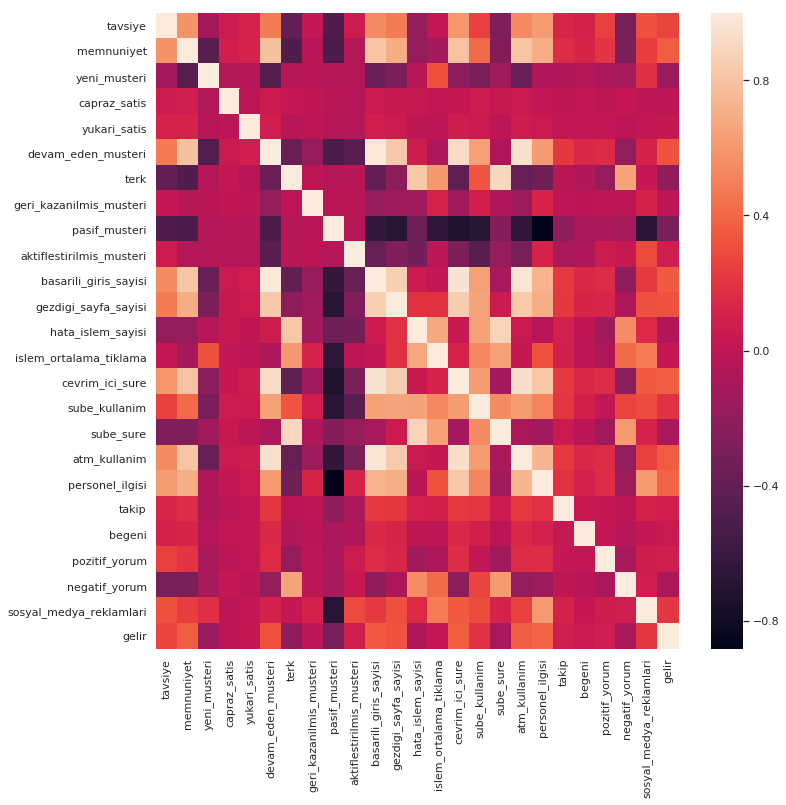

In [40]:
import seaborn as sns; sns.set()
from matplotlib import pyplot
a4_dims = (11.7, 11.7)
fig, ax = pyplot.subplots(figsize=a4_dims)
corrfig = sns.heatmap(ax=ax, data=data.corr())
corrfig.figure.savefig("corr.pdf")

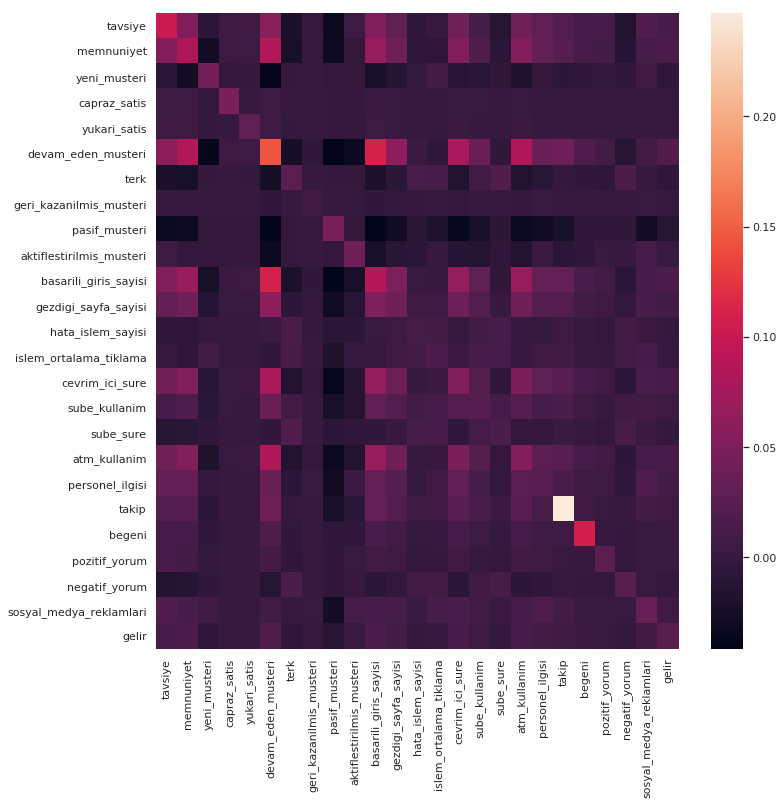

In [41]:
a4_dims = (11.7, 11.7)
fig, ax = pyplot.subplots(figsize=a4_dims)
corrfig = sns.heatmap(ax=ax, data=data.cov())
corrfig.figure.savefig("cov.pdf")